In [118]:
# To ignore warnings

import os, warnings
warnings.filterwarnings('ignore')

In [119]:
# Import necessary libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [120]:
# Load and preprocess the COVID-19 dataset

url = "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv" # URL for the COVID-19 dataset
df = pd.read_csv(url)

df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Country/Region'] == 'US']
df.fillna(0, inplace=True)

In [121]:
# Feature engineering

df['New_Cases'] = df['Confirmed'].diff().fillna(0)

In [122]:
# Split the data into training and testing sets

start_date = pd.Timestamp('2020-03-01')
end_date = pd.Timestamp('2020-03-21')
df_train = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

test_start_date = pd.Timestamp('2020-03-22')
test_end_date = pd.Timestamp('2020-03-25')
df_test = df[(df['Date'] >= test_start_date) & (df['Date'] <= test_end_date)]

In [123]:
# Prepare the data for modeling mentioned in Section 5.2 (Univariate approach)
target = ['New_Cases']

train_data = df_train[target].values
test_data = df_test[target].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [145]:
# Function to create sequences of data for training and testing

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


In [146]:
# Create sequences for training and testing

seq_length = 1  # Number of days to look back
X_train, y_train = create_sequences(scaled_train_data, seq_length)
X_test, y_test = create_sequences(scaled_test_data, seq_length)


In [147]:
# Reshaping the data for the model

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [148]:
# Define and compile the model as mentioned in Table 4

input_layer = Input(shape=(seq_length, 1))
x = TimeDistributed(Dense(128))(input_layer)
x = MultiHeadAttention(num_heads=8, key_dim=16)(x, x)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)
x = TimeDistributed(Dense(64, activation='relu'))(x)
x = GlobalAveragePooling1D()(x)
output_layer = Dense(1)(x)
model = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [149]:
# Define callbacks for training

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [150]:
# Train the model

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.6333 - val_loss: 0.3442 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0143 - val_loss: 0.0184 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0557 - val_loss: 0.8329 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0573 - val_loss: 0.7127 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 58ms/step - loss: 0.0798 - val_loss: 0.0298 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 60ms/step - loss: 0.0194 - val_loss: 0.0627 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 0s 46ms/step - loss: 0.0765 - val_loss: 0.0172 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - 0s 68ms/step - loss: 0.0329 - val_loss: 0.3479 - lr: 0.0010
Epoch 9/100
1/1 [==============================] - 0s 61ms/step - loss: 0.0228 - val_loss: 0.8634 - lr: 0.0010
Epo

In [151]:
# Make predictions

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)


1/1 [==============================] - 0s 161ms/step


In [152]:
y_test

array([[11152.],
       [10618.],
       [12127.]])

In [153]:
predictions

array([[10422.9  ],
       [11142.299],
       [10997.803]], dtype=float32)

In [154]:
# Evaluate the predictions

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)

print(f'Root Mean Squared Error for Transformer: {rmse}')
print(f'Mean Absolute Percentage Error Transformer: {mape}')


Root Mean Squared Error for Transformer: 832.978984580644
Mean Absolute Percentage Error Transformer: 0.0692903294700765


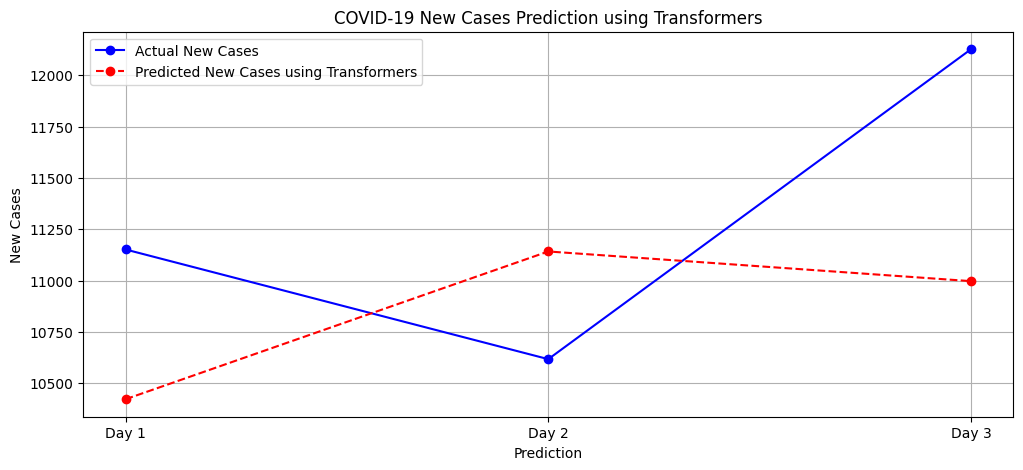

In [156]:
# Visualize the predictions as shown in Figure 6

days = ["Day 1", "Day 2", "Day 3"]
actual_new_cases = y_test
predicted_new_cases = predictions

plt.figure(figsize=(12, 5))

plt.plot(days, actual_new_cases, marker='o', linestyle='-', color='blue', label='Actual New Cases')
plt.plot(days, predicted_new_cases, marker='o', linestyle='--', color='red', label='Predicted New Cases using Transformers')

plt.title('COVID-19 New Cases Prediction using Transformers')
plt.xlabel('Prediction')
plt.ylabel('New Cases')

plt.legend()

plt.grid(True)
plt.show()